[![AnalyticsDojo](https://github.com/rpi-techfundamentals/spring2019-materials/blob/master/fig/final-logo.png?raw=1)](http://rpi.analyticsdojo.com)
<center><h1>KNN  </h1></center>
<center><h3><a href = 'http://introml.analyticsdojo.com'>introml.analyticsdojo.com</a></h3></center>



# KNN 

In [13]:
#Let's get rid of some imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [14]:
from sklearn.datasets import load_iris

#Iris is available from the sklearn package
iris = load_iris()
X, y = iris.data, iris.target



Thinking about how machine learning is normally performed, the idea of a train/test split makes sense. Real world systems train on the data they have, and as other data comes in (from customers, sensors, or other sources) the classifier that was trained must predict on fundamentally *new* data. We can simulate this during training using a train/test split - the test data is a simulation of "future data" which will come into the system during production. 

Specifically for iris, the 150 labels in iris are sorted, which means that if we split the data using a proportional split, this will result in fudamentally altered class distributions. For instance, if we'd perform a common 2/3 training data and 1/3 test data split, our training dataset will only consists of flower classes 0 and 1 (Setosa and Versicolor), and our test set will only contain samples with class label 2 (Virginica flowers).

Under the assumption that all samples are independent of each other (in contrast time series data), we want to **randomly shuffle the dataset before we split the dataset** as illustrated above.

In [15]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Shuffling Dataset 

- Now we need to split the data into training and testing. 
- Luckily, this is a common pattern in machine learning and scikit-learn has a pre-built function to split data into training and testing sets for you. 
- Here, we use 50% of the data as training, and 50% testing. 
- 80% and 20% is another common split, but there are no hard and fast rules. 
- The most important thing is to fairly evaluate your system on data it *has not* seen during training!

In [16]:
#Import Module
from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.5,
                                                    test_size=0.5,
                                                    random_state=123)
print("Labels for training and testing data")
print(train_y)
print(test_y)

Labels for training and testing data
[1 1 0 2 2 0 0 1 1 2 0 0 1 0 1 2 0 2 0 0 1 0 0 1 2 1 1 1 0 0 1 2 0 0 1 1 1
 2 1 1 1 2 0 0 1 2 2 2 2 0 1 0 1 1 0 1 2 1 2 2 0 1 0 2 2 1 1 2 2 1 0 1 1 2
 2]
[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 2 0 2 0 0 0 2 2 0 2 2 0 0 1 1 2
 0 0 1 1 0 2 2 2 2 2 1 0 0 2 0 0 1 1 1 1 2 1 2 0 2 1 0 0 2 1 2 2 0 1 1 2 0
 2]


---

### Stratified Splitting

- Especially for relatively small datasets, it's better to stratify the split.  
- Stratification means that we maintain the original class proportion of the dataset in the test and training sets. 
- For example, after we randomly split the dataset as shown in the previous code example, we have the following class proportions in percent:

In [17]:
print('All:', np.bincount(y) / float(len(y)) * 100.0)
print('Training:', np.bincount(train_y) / float(len(train_y)) * 100.0)
print('Test:', np.bincount(test_y) / float(len(test_y)) * 100.0)

All: [33.33333333 33.33333333 33.33333333]
Training: [30.66666667 40.         29.33333333]
Test: [36.         26.66666667 37.33333333]


So, in order to stratify the split, we can pass the label array as an additional option to the `train_test_split` function:

In [18]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.5,
                                                    test_size=0.5,
                                                    random_state=123,
                                                    stratify=y)

print('All:', np.bincount(y) / float(len(y)) * 100.0)
print('Training:', np.bincount(train_y) / float(len(train_y)) * 100.0)
print('Test:', np.bincount(test_y) / float(len(test_y)) * 100.0)

All: [33.33333333 33.33333333 33.33333333]
Training: [33.33333333 33.33333333 33.33333333]
Test: [33.33333333 33.33333333 33.33333333]


---

### Prediction using Simple Nearest Neighbor Classifier 
- By evaluating our classifier performance on data that has been seen during training, we could get false confidence in the predictive power of our model. 
- In the worst case, it may simply memorize the training samples but completely fails classifying new, similar samples -- we really don't want to put such a system into production!
- Instead of using the same dataset for training and testing (this is called "resubstitution evaluation"), it is much much better to use a train/test split in order to estimate how well your trained model is doing on new data.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
#This creates a model object.
classifier = KNeighborsClassifier()
#This fits the model object to the data.
classifier.fit(train_X, train_y)
#This creates the prediction. 
pred_y = classifier.predict(test_X)


/Users/minor/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Scoring 
- We can manually calculate the accuracy as we have done before. 
- `metrics.accuracy_score` is passed the target value and the predicted value.Model objects also built in scoring functions.
- Can also us a `classifier.score` component built into the model. 

In [20]:
from sklearn import metrics

#This calculates the accuracy.
print("Manual Accuracy:", np.sum(pred_y == test_y) / float(len(test_y)))
print("Metrics score: ", metrics.accuracy_score(test_y, pred_y) )
print("Classifier score: ", classifier.score(test_X, test_y) )


Manual Accuracy: 0.96
Metrics score:  0.96
Classifier score:  0.96


/Users/minor/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Cross Validation
- Teh `cv` parameter is the number of folds.
- Scoring type depends on whether classification, clustering, regression.

In [21]:
from sklearn.model_selection import cross_val_score
cv1 = cross_val_score(classifier, train_X, train_y, cv=2, scoring='accuracy')
cv10 = cross_val_score(classifier, train_X, train_y, cv=10, scoring='accuracy')
print("Two-fold cross validation:", cv1)
print("Ten-fold cross validation:", cv10)


Two-fold cross validation: [0.97368421 0.97297297]
Ten-fold cross validation: [1.    0.875 0.875 1.    1.    1.    1.    1.    1.    1.   ]


/Users/minor/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/minor/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

### Visualizing Errors

We can also visualize the correct and failed predictions.

In [22]:
print('Samples correctly classified:')
correct_idx = np.where(pred_y == test_y)[0]
print(correct_idx)

print('\nSamples incorrectly classified:')
incorrect_idx = np.where(pred_y != test_y)[0]
print(incorrect_idx)

Samples correctly classified:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48
 50 51 52 53 54 55 56 57 58 59 61 62 63 64 65 66 67 68 69 70 71 72 73 74]

Samples incorrectly classified:
[44 49 60]


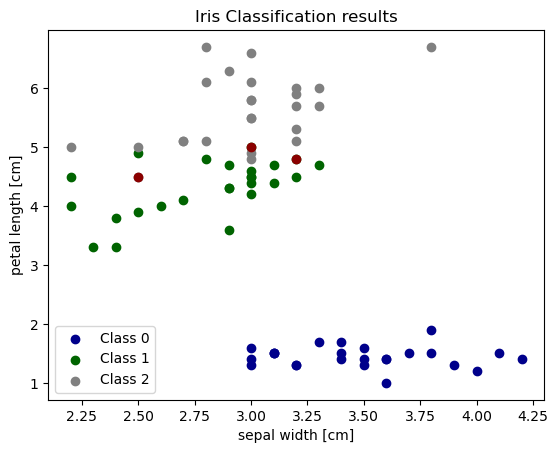

In [23]:
# Plot two dimensions

colors = ["darkblue", "darkgreen", "gray"]

for n, color in enumerate(colors):
    idx = np.where(test_y == n)[0]
    plt.scatter(test_X[idx, 1], test_X[idx, 2], color=color, label="Class %s" % str(n))

plt.scatter(test_X[incorrect_idx, 1], test_X[incorrect_idx, 2], color="darkred")

plt.xlabel('sepal width [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc=3)
plt.title("Iris Classification results")
plt.show()

We can see that the errors occur in the area where green (class 1) and gray (class 2) overlap. This gives us insight about what features to add - any feature which helps separate class 1 and class 2 should improve classifier performance.

### Nearest Neighbor Classification
- [Documentation](http://scikit-learn.org/stable/modules/neighbors.html) and [Function](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).
- Various ways of tuning the model to take into account K neighbors or weighted values.
- Generally, larger values of k reduce the effect of noise on the classification.
- Weighted models can also be used, where closer neighbors are weighted more highly.

### Hyperparameter Tuning
- Hyperparameters are the various settings you can provide to an algorithm.
- For example, you could detrmine the number of neighors or the weighting method used.

In [27]:
classifier = KNeighborsClassifier(n_neighbors=10)
#This fits the model object to the data.
classifier.fit(train_X, train_y)
#This creates the prediction. 
pred_y = classifier.predict(test_X)
print("Metrics score: ", metrics.accuracy_score(test_y, pred_y) )

Metrics score:  0.9866666666666667


/Users/minor/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
